## OVERFITTING

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import joblib
import time
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_path = "../data/final_hybrid_data/benign_ddos_bf_dataset.csv"

df = pd.read_csv(data_path)

In [3]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

print(f"Temizleme öncesi satır sayısı: {len(df)}")
df.dropna(inplace=True)
print(f"Temizleme sonrası satır sayısı: {len(df)}")

df.reset_index(drop=True, inplace=True)
print(f"Kalan NaN sayısı: {df.isnull().sum().sum()}")
print(f"Kalan Inf sayısı: {np.isinf(df.select_dtypes(include = np.number)).values.sum()}")

Temizleme öncesi satır sayısı: 1142847
Temizleme sonrası satır sayısı: 1139940
Kalan NaN sayısı: 0
Kalan Inf sayısı: 0


In [4]:
print("Veri Seti İçerisindeki Sınıf Dağılımı:")
print(df['Label'].value_counts())

Veri Seti İçerisindeki Sınıf Dağılımı:
Label
2    380949
1    380946
0    378045
Name: count, dtype: int64


In [5]:
selected_features = [
    'Init_Win_bytes_forward', 
    'Init_Win_bytes_backward', 
    'Fwd Header Length', 
    'Max Packet Length', 
    'Flow IAT Min', 
    'Flow IAT Max', 
    'Fwd Packets/s', 
    'Bwd Packets/s', 
    'Fwd Packet Length Std',
    'Label'
]

In [6]:
df = df[selected_features]

In [7]:
df.head(2)

,Init_Win_bytes_forward,Init_Win_bytes_backward,Fwd Header Length,Max Packet Length,Flow IAT Min,Flow IAT Max,Fwd Packets/s,Bwd Packets/s,Fwd Packet Length Std,Label
0,63964,-1,40,0.0,138.0,138.0,14492.753623,0.000000,0.000000,0
1,8192,62852,172,1173.0,4.0,953296.0,2.580082,2.580082,228.129662,0


In [8]:
X = df.drop(columns = "Label")
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0, stratify = y)

In [9]:
# Veriyi Ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # Test Verisini fit_transform yapmıyoruz

In [10]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state = 0),
    "Random Forest": RandomForestClassifier(n_estimators = 100, n_jobs=-1, random_state = 0), # n_jobs=-1 tüm işlemcileri kullanır
    "Logistic Regression": LogisticRegression(max_iter = 1000, n_jobs=-1, random_state = 0),
    
    # Boosting Modelleri
    "XGBoost": XGBClassifier(
        eval_metric = 'mlogloss', 
        use_label_encoder = False, 
        n_jobs = -1, 
        random_state = 0
    ),
    "LightGBM": LGBMClassifier(
        n_jobs = -1, 
        random_state = 0, 
        verbose = -1 # loglar kapalı
    ),
    "CatBoost": CatBoostClassifier(
        verbose = 0, # loglar kapalı
        random_state = 42,
        thread_count = -1
    )
}

results_df = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score", "CV Mean Score", "Time"])

In [11]:
print(f"{'-'*20} EĞİTİM BAŞLIYOR {'-'*20}")
print(f"Toplam Veri Sayısı: {len(df)}")
print(f"Modeller: {', '.join(models.keys())}\n")

# EĞİTİM DÖNGÜSÜ
for name, model in models.items():
    start_time = time.time()
    
    # Boosting ve Ağaçlar için ölçeklenmemiş, LogReg için ölçeklenmiş veri kullanalıyorum
    # Not: Boosting algoritmaları ölçekli veriyle de gayet iyi çalışır.
    if name == "Logistic Regression":
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train, X_test
        
    # Model eğitimi
    model.fit(X_tr, y_train)
    
    # Tahmin
    y_pred = model.predict(X_te)
    
    # Metrikler
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Cross Validation 
    # 1 Milyondan fazla satır olduğu için cv 3'e düşürüldü
    cv_scores = cross_val_score(model, X_tr, y_train, cv = 3, scoring = 'f1_macro', n_jobs = -1)
    cv_mean = cv_scores.mean()
    
    elapsed_time = time.time() - start_time
    
    # Kayıtlar
    new_row = pd.DataFrame({
        "Model": [name], "Accuracy": [acc], "Precision": [prec], 
        "Recall": [rec], "F1-Score": [f1], "CV Mean Score": [cv_mean],
        "Time (s)": [round(elapsed_time, 2)]
    })
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    print(f"Model Tamamlandı: {name} (Süre: {elapsed_time:.2f}sn)")

# SONUÇLARI SIRALA VE GÖSTER
results_df = results_df.sort_values(by = "F1-Score", ascending = False).reset_index(drop = True) # F1-Score'a göre model sıralaması

-------------------- EĞİTİM BAŞLIYOR --------------------
Toplam Veri Sayısı: 1139940
Modeller: Decision Tree, Random Forest, Logistic Regression, XGBoost, LightGBM, CatBoost

Model Tamamlandı: Decision Tree (Süre: 14.22sn)
Model Tamamlandı: Random Forest (Süre: 136.06sn)
Model Tamamlandı: Logistic Regression (Süre: 27.85sn)
Model Tamamlandı: XGBoost (Süre: 25.27sn)
Model Tamamlandı: LightGBM (Süre: 16.76sn)
Model Tamamlandı: CatBoost (Süre: 381.19sn)


In [12]:
print("\n" + "="*60)
print("PERFORMANS SIRALAMASI (F1-SCORE BAZLI)")
print("="*60)
print(results_df)


PERFORMANS SIRALAMASI (F1-SCORE BAZLI)
                 Model  Accuracy  Precision    Recall  F1-Score  \
0             LightGBM  0.999719   0.999719  0.999719  0.999719   
1              XGBoost  0.999675   0.999675  0.999675  0.999675   
2        Random Forest  0.999667   0.999666  0.999667  0.999666   
3             CatBoost  0.999640   0.999640  0.999640  0.999640   
4        Decision Tree  0.999570   0.999569  0.999570  0.999570   
5  Logistic Regression  0.856677   0.860627  0.856253  0.854064   

   CV Mean Score Time  Time (s)  
0       0.999766  NaN     16.76  
1       0.999723  NaN     25.27  
2       0.999665  NaN    136.06  
3       0.999689  NaN    381.19  
4       0.999577  NaN     14.22  
5       0.852896  NaN     27.85  



En İyi Model: LightGBM ile görselleştirme yapılıyor...


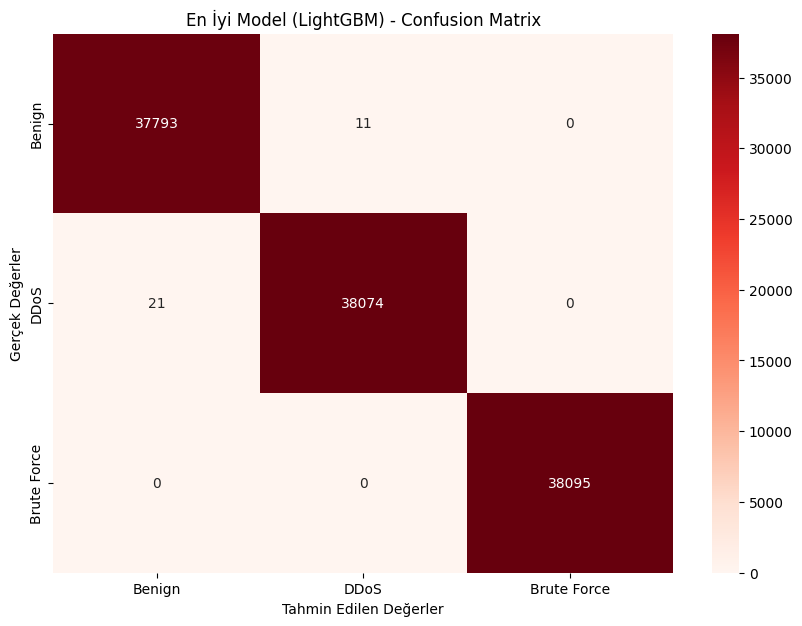

In [13]:
# En iyi modeli seçip confusion matrixine bir bakalım
best_model_name = results_df.iloc[0]["Model"]

print(f"\nEn İyi Model: {best_model_name} ile görselleştirme yapılıyor...")

best_model = models[best_model_name]

# Log Reg modeline scaled veri vermiştik onu unutmayalım
if best_model_name == "Logistic Regression":
    y_pred_best = best_model.predict(X_test_scaled)
else:
    y_pred_best = best_model.predict(X_test) # Diğer modeller scaled olmasa da çalışır

cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['Benign', 'DDoS', 'Brute Force'], 
            yticklabels=['Benign', 'DDoS', 'Brute Force'])
plt.title(f'En İyi Model ({best_model_name}) - Confusion Matrix')
plt.ylabel('Gerçek Değerler')
plt.xlabel('Tahmin Edilen Değerler')
plt.show()

In [14]:
results_df.drop(columns = 'Time')

,Model,Accuracy,Precision,Recall,F1-Score,CV Mean Score,Time (s)
0,LightGBM,0.999719,0.999719,0.999719,0.999719,0.999766,16.76
1,XGBoost,0.999675,0.999675,0.999675,0.999675,0.999723,25.27
2,Random Forest,0.999667,0.999666,0.999667,0.999666,0.999665,136.06
3,CatBoost,0.999640,0.999640,0.999640,0.999640,0.999689,381.19
4,Decision Tree,0.999570,0.999569,0.999570,0.999570,0.999577,14.22
5,Logistic Regression,0.856677,0.860627,0.856253,0.854064,0.852896,27.85



 MODELLERE GÖRE EN ÖNEMLİ 10 ÖZELLİK

--- Decision Tree ---
Init_Win_bytes_forward         : 0.55654
Init_Win_bytes_backward        : 0.33623
Fwd Packet Length Std          : 0.04033
Flow IAT Min                   : 0.02462
Bwd Packets/s                  : 0.02218
Fwd Packets/s                  : 0.01253
Fwd Header Length              : 0.00550
Max Packet Length              : 0.00109
Flow IAT Max                   : 0.00098

--- Random Forest ---
Init_Win_bytes_forward         : 0.24673
Init_Win_bytes_backward        : 0.20076
Fwd Header Length              : 0.11583
Bwd Packets/s                  : 0.11556
Fwd Packets/s                  : 0.11037
Flow IAT Max                   : 0.07868
Max Packet Length              : 0.04999
Fwd Packet Length Std          : 0.04238
Flow IAT Min                   : 0.03971

--- Logistic Regression ---
Fwd Packets/s                  : 37.21966
Flow IAT Max                   : 14.15519
Init_Win_bytes_backward        : 9.87481
Bwd Packets/s           

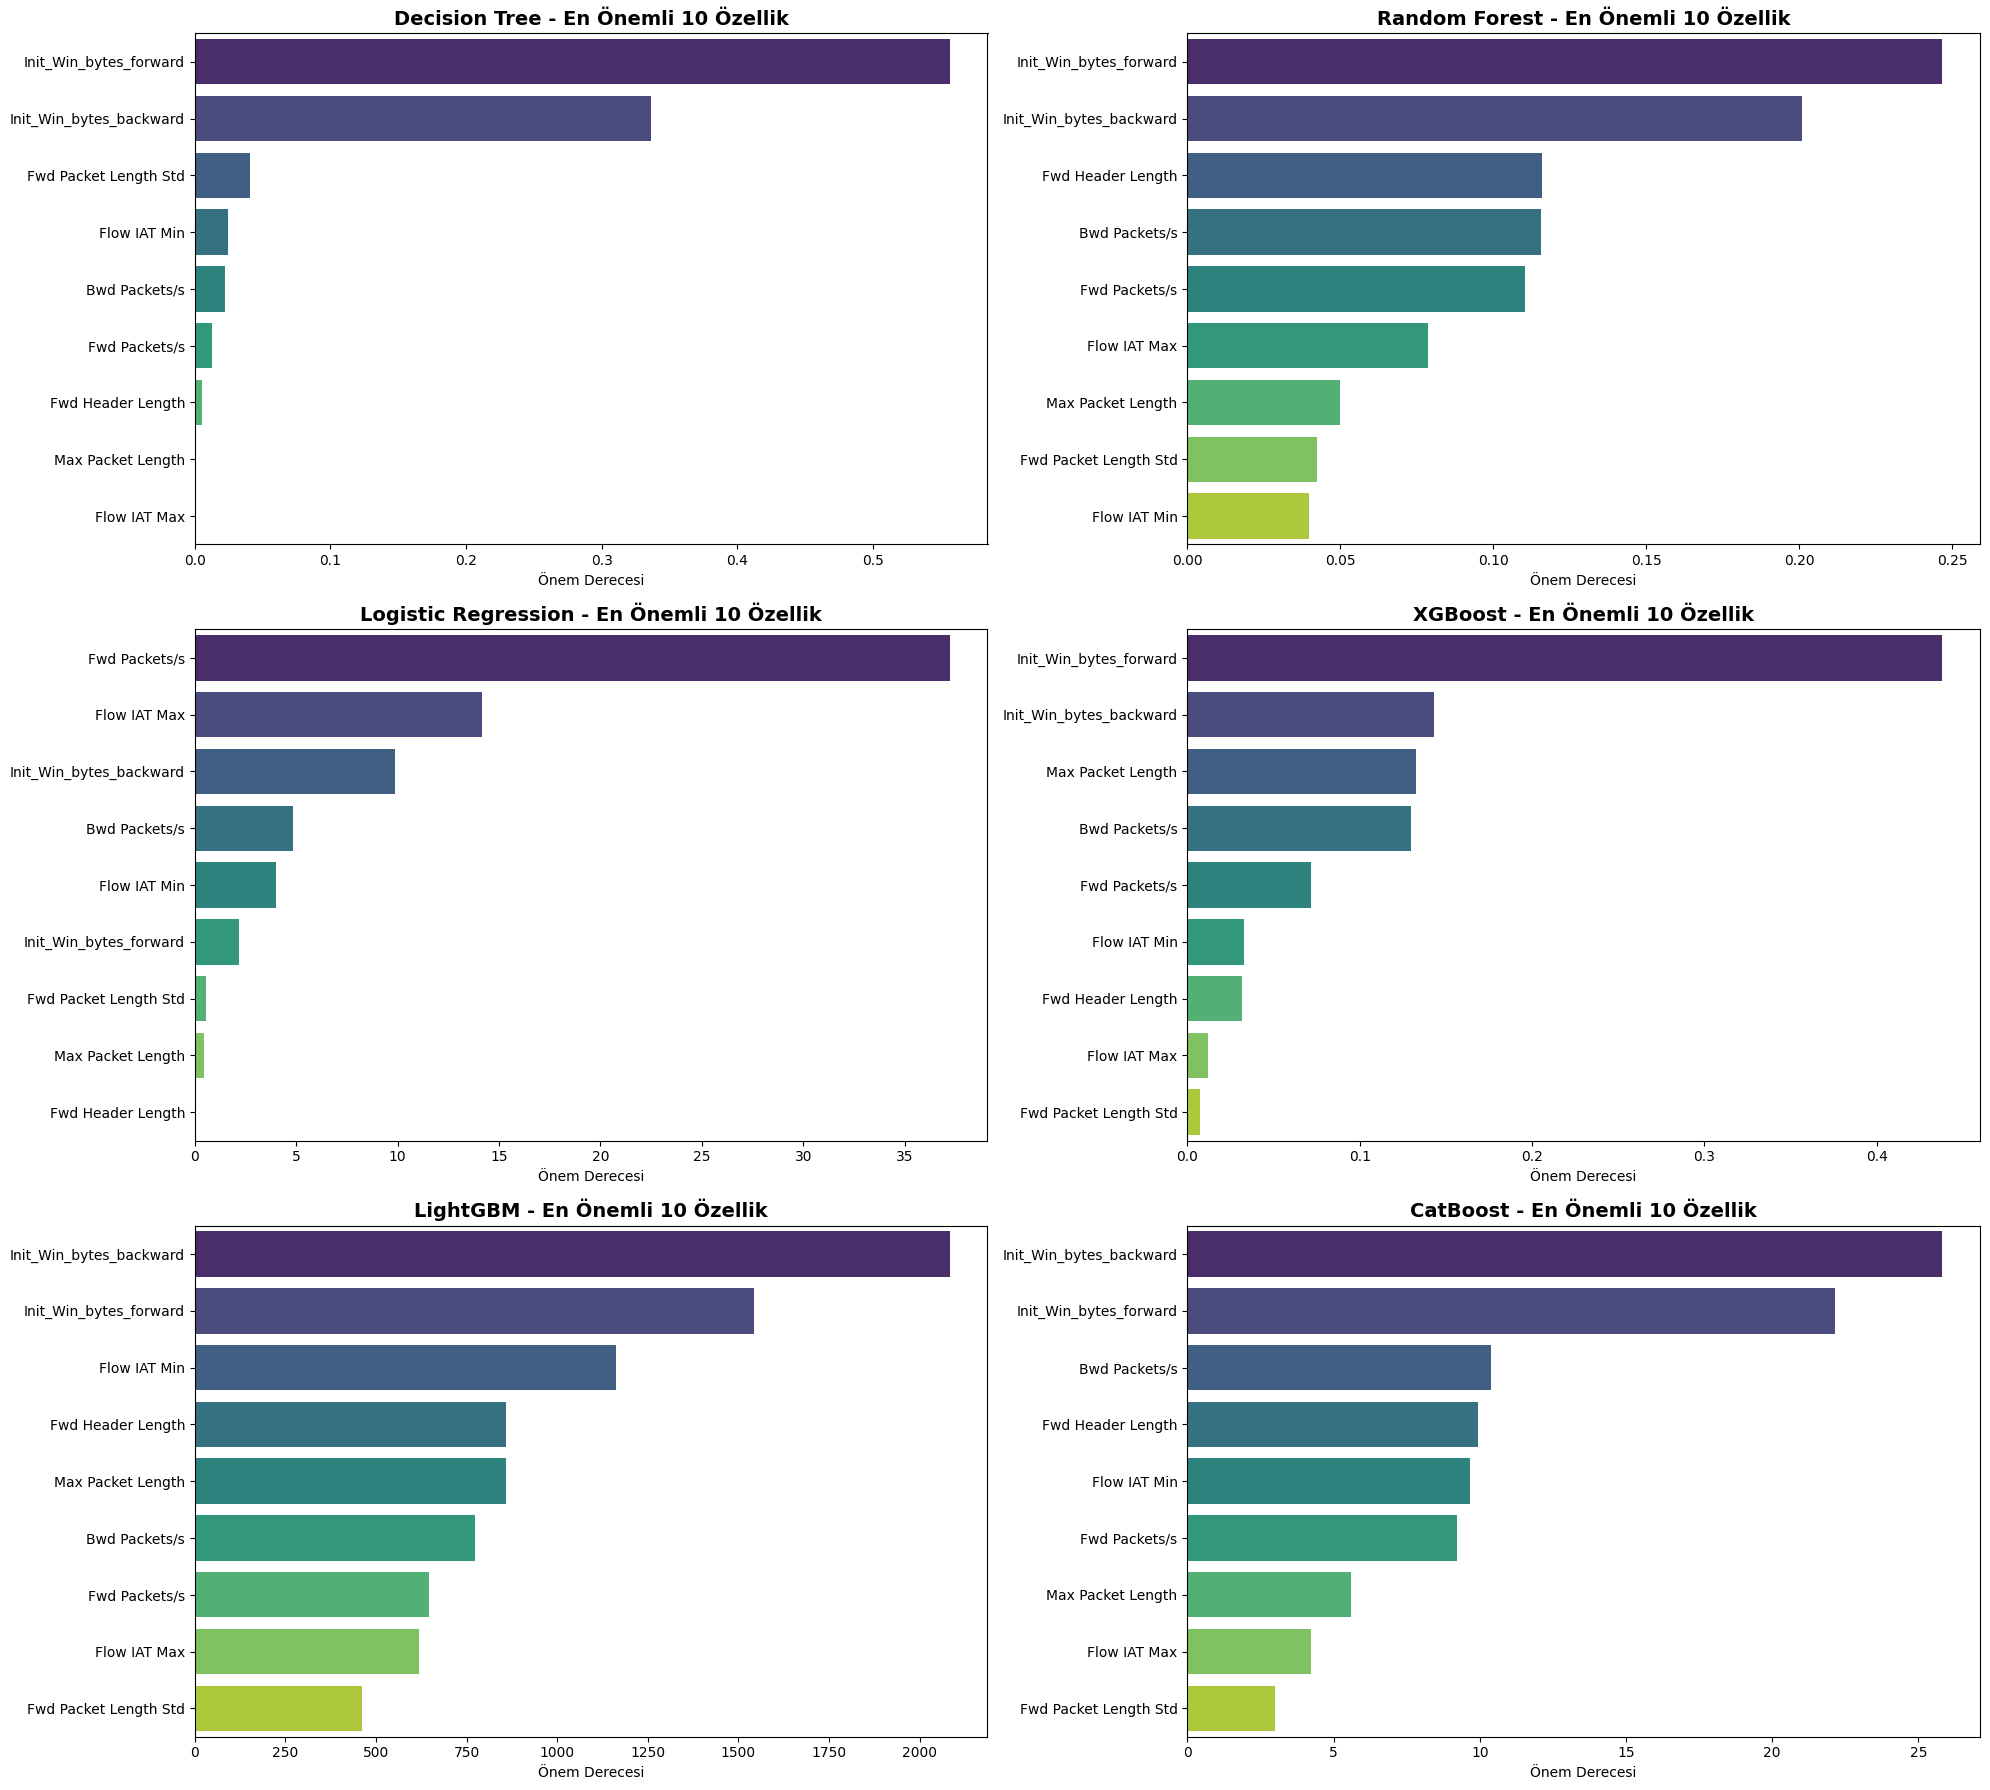

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 18))
axes = axes.flatten()

feature_names = X.columns

print("\n" + "="*40)
print(" MODELLERE GÖRE EN ÖNEMLİ 10 ÖZELLİK")
print("="*40)

for i, (name, model) in enumerate(models.items()):
    # Önem Değerlerini Çekme
    try:
        if name == "Logistic Regression":
            # Logistic Regression katsayı kullanır.
            # 3 sınıf olduğu için katsayıların mutlak değerlerinin ortalamasını alıyoruz.
            importances = np.mean(np.abs(model.coef_), axis=0)
        elif name == "CatBoost":
            importances = model.get_feature_importance()
        else:
            # Diğer ağaç tabanlı modeller için fonksiyon ismi aynı
            importances = model.feature_importances_
            
        # DataFrame Oluşturma ve Sıralama İşlemi
        feature_imp_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        })
        
        # En yüksek 10 özelliği seçiyoruz
        top_10 = feature_imp_df.sort_values(by = 'Importance', ascending = False).head(10)
        
        # Yazılı Çıktılar
        print(f"\n--- {name} ---")
        for index, row in top_10.iterrows():
            print(f"{row['Feature']:<30} : {row['Importance']:.5f}")
            
        # Görselleştirme
        sns.barplot(x='Importance', y='Feature', data = top_10, ax = axes[i], palette = 'viridis')
        axes[i].set_title(f'{name} - En Önemli 10 Özellik', fontsize = 14, fontweight = 'bold')
        axes[i].set_xlabel('Önem Derecesi')
        axes[i].set_ylabel('')
        
    except Exception as e:
        print(f"{name} için feature importance hesaplanamadı: {e}")
        # Hata durumunda boş grafiği gizleyecek
        axes[i].axis('off')

plt.tight_layout()
plt.show()

In [16]:
import joblib
import os

save_path = "../models/MultiClass_Models/Model/benign_ddos_bf_model_balanced.pkl"

joblib.dump(best_model, save_path)

print(f"Model başarıyla '{save_path}' olarak kaydedildi.")

Model başarıyla '../models/MultiClass_Models/Model/benign_ddos_bf_model_balanced.pkl' olarak kaydedildi.
